# **필요한 라이브러리 불러오기**

In [10]:
!pip install ultralytics -q
!pip install mediapipe -q
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import cv2 as cv
import mediapipe as mp
import numpy as np
import sys
import pandas as pd
import os
import math
import itertools
import matplotlib.pyplot as plt

# **영상별 손 좌표 및 각도 데이터 추출**

## **관련 설정**

In [ ]:
# 공통 설정
## 파일 저장 경로 지정
input_put_videos_path = '/content/input_videos/put/'
input_rotate_videos_path = '/content/input_videos/rotate/'
put_file_list = [[input_put_videos_path + name, name] for name in os.listdir(input_put_videos_path) if name[-3:] == 'MOV']
rotate_file_list = [[input_rotate_videos_path + name, name] for name in os.listdir(input_rotate_videos_path) if name[-3:] == 'MOV']
processed_put_videos_path = '/content/processed_videos/put/'
processed_rotate_videos_path = '/content/processed_videos/rotate/'

## 각도값 및 좌표값을 담은 csv 파일명 지정
rotate_file_name = '/content/lstm_rotate.csv'
put_file_name = '/content/put_rotate.csv'

## 각도값 및 좌표값을 담은 데이터프레임의 형태 지정
set_columns_put = ['file_name', 'frame'] + [f'lm{lm}_{i}' for lm in [0, 1, 5, 9, 13, 17] for i in ['x','y']]
set_columns_rotate = ['file_name', 'frame'] + [f'angle_{i+1}' for i in range(12)]
final_result_put = pd.DataFrame(columns = set_columns_put)
final_result_rotate = pd.DataFrame(columns = set_columns_rotate)

## YOLO 모델이 검출하는 label number별 객체명 지정
label_dict = {0 : 'back',
              1 : 'bottom',
              2 : 'error',
              3 : 'front',
              4 : 'hand',
              5 : 'head',
              6 : 'side'}

# YOLOv5s 관련 설정
yolo_model_path = '/content/custom_yolov5s.onnx' # 훈련된 YOLOv5s 모델 지정
yolo_offset = 75

# Mediapipe 관련 설정
mp_hand = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles
max_num_hands = 1
static_image_mode = True
min_detection_confidence = 0.2
min_tracking_confidence = 0.3
hand = mp_hand.Hands(max_num_hands = max_num_hands,
                     static_image_mode = static_image_mode,
                     min_detection_confidence = min_detection_confidence,
                     min_tracking_confidence = min_tracking_confidence)

## **훈련된 YOLOv5s 모델 불러오기**

In [ ]:
yolo5 = torch.hub.load('ultralytics/yolov5', 'custom', path = yolo_model_path)
yolo5.eval()
yolo5.amp = True

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-30 Python-3.10.6 torch-2.0.1+cu118 CPU

Loading /content/custom_yolov5s.onnx for ONNX Runtime inference...
Adding AutoShape... 


## **동영상에서 손 랜드마크별 좌표값 및 랜드마크 간 각도값 추출하기**

In [ ]:
for cat, file_list in enumerate([put_file_list, rotate_file_list]):
  for i, (video_file, video_name) in enumerate(file_list):

      cap = cv.VideoCapture(video_file)
      frame_num = 1

      if cat == 0:
        lm_info = []
      else:
        angle_info = []

      fps = cap.get(cv.CAP_PROP_FPS)
      width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
      height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)

      codec = 'mp4v' if video_name.split('.')[1]=='mov' else 'MP4V' # 코덱
      fourcc = cv.VideoWriter_fourcc(*codec)

      if cat == 0:
        out = cv.VideoWriter(processed_put_videos_path+video_name, fourcc, fps, (int(width), int(height)))
      else:
        out = cv.VideoWriter(processed_rotate_videos_path+video_name, fourcc, fps, (int(width), int(height)))

      while True:
          ret, frame = cap.read()

          if not cap.isOpened():
              sys.exit('Fail to file loading')
          if not ret:
              break

          print('----- Processing %50s | frame : %3d -----' % (video_file, frame_num)  , end='\r')

          # yolo 모델에서 손을 비롯한 객체 검출
          pred = yolo5(cv.cvtColor(frame, cv.COLOR_BGR2RGB)).pred[0].numpy()

          # 영상에서 손이 검출되지 않으면 NaN값을 채워넣음
          if not 4 in list(pred[:, 5]):
            tmp = [np.nan for i in range(12)]
            if cat == 0:
              lm_info.append([video_name, frame_num] + tmp)
            else:
              angle_info.append([video_name, frame_num] + list(tmp))

          # 영상에서 1개 이상의 객체가 검출되면 손 랜드마크별 좌표 및 랜드마크간 각도 값 추출
          if pred.shape[0] != 0:
              for i in range(pred.shape[0]):
                  x_ul, y_ul, x_lr, y_lr, conf, class_ = list(map(int, (pred[i, :4]))) + list(pred[i, 4:])
                  if conf >= min_detection_confidence:
                      if class_ == 4:

                          # YOLO 단계에서 도출된 '손'의 바운딩 박스 내에서만 랜드마크 검출
                          # 랜드마크 검출의 정확성을 높이기 위해 일정 범위의 OFFSET 적용
                          hand_frame = np.zeros((frame.shape[0], frame.shape[1], 3), np.uint8)
                          x_ul = x_ul if x_ul - yolo_offset <= 0 else x_ul - yolo_offset
                          x_lr = x_lr + yolo_offset if x_lr + yolo_offset <= frame.shape[1] else x_lr
                          y_ul = y_ul if y_ul - yolo_offset <= 0 else y_ul - yolo_offset
                          hand_frame[y_ul:y_lr, x_ul:x_lr] = frame[y_ul:y_lr, x_ul:x_lr]
                          res = hand.process(cv.cvtColor(hand_frame, cv.COLOR_BGR2RGB))

                          # 랜드마크별 좌표 및 랜드마크간 각도값 추출
                          if res.multi_hand_landmarks:
                              for landmarks in res.multi_hand_landmarks:
                                  mp_drawing.draw_landmarks(frame,
                                                            landmarks,
                                                            mp_hand.HAND_CONNECTIONS,
                                                            mp_styles.get_default_hand_landmarks_style(),
                                                            mp_styles.get_default_hand_connections_style())
                                  # 내려놓는 동작은 랜드마크별 x, y 좌표를 추출
                                  if cat == 0:
                                    tmp = []
                                    for j, lm in enumerate(landmarks.landmark):
                                      if j in [0, 1, 5, 9, 13, 17]:
                                        tmp.extend([lm.x, lm.y])
                                    lm_info.append([video_name, frame_num] + tmp)

                                  # 회전하는 동작은 랜드마크간 각도를 추출
                                  else:
                                    joint = np.zeros((21, 3))
                                    for j, lm in enumerate(landmarks.landmark):
                                        joint[j] = [lm.x, lm.y, lm.z]
                                    v1 = joint[[0, 1, 0, 5, 0, 0 , 0 , 5, 9 , 13]]
                                    v2 = joint[[1, 2, 5, 6, 9, 13, 17, 9, 13, 17]]
                                    v = v2 - v1
                                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]
                                    angle = np.arccos(np.einsum('nt,nt->n',
                                                                v[[1, 0, 2, 4, 5, 7, 3, 4, 8, 5, 9, 6],:],
                                                                v[[0, 2, 4, 5, 6, 2, 7, 7, 4, 8, 5, 9],:]))
                                    angle = np.degrees(angle)
                                    angle_info.append([video_name, frame_num] + list(angle))

                          # 손 좌표값이 없을 경우 NaN값 처리
                          else:
                            tmp = [np.nan for i in range(12)]
                            if cat == 0:
                              lm_info.append([video_name, frame_num] + tmp)
                            else:
                              angle_info.append([video_name, frame_num] + list(tmp))

                      # YOLO 바운딩 박스 그리기
                      cv.rectangle(frame,
                                   (x_ul, y_ul),
                                   (x_lr, y_lr),
                                   (100, 100, 100),
                                   5)

                      # 검출한 객체 표시하기
                      cv.putText(frame,
                                 label_dict[int(class_)],
                                 (x_ul, y_ul-10),
                                 cv.FONT_HERSHEY_SIMPLEX,
                                 1,
                                 (255, 0, 0),
                                 2)

                      # 검출 신뢰도 표시하기
                      cv.putText(frame,
                                 str(round(conf, 2)),
                                 (x_ul + 100, y_ul-10),
                                 cv.FONT_HERSHEY_SIMPLEX,
                                 1,
                                 (255, 0, 0),
                                 2)

                      # 현재 프레임 순서 표시하기
                      cv.putText(frame,
                                 str(frame_num),
                                 (60, 90),
                                 cv.FONT_HERSHEY_SIMPLEX,
                                 2,
                                 (255, 51, 255),
                                 3)

          frame_num += 1

          out.write(frame)
          cv.waitKey(1)

      out.release()
      cap.release()
      cv.destroyAllWindows()

      # 추출한 데이터를 데이터 프레임에 이어 붙이기
      if cat == 0:
        test = pd.DataFrame(lm_info, columns = set_columns_put)
        final_result_put = pd.concat([final_result_put, test])
      else:
        test = pd.DataFrame(angle_info, columns = set_columns_rotate)
        final_result_rotate = pd.concat([final_result_rotate, test])

  # 만들어진 데이터 프레임을 csv 파일로 내보내기
  if cat == 0:
    final_result_put.sort_values(by=['file_name', 'frame'], ascending=[True, True]).to_csv(f'{put_file_name}', encoding='utf-8')
    print('----- Complete creating dataset : %50s' % put_file_name)
  else:
    final_result_rotate.sort_values(by=['file_name', 'frame'], ascending=[True, True]).to_csv(f'{rotate_file_name}', encoding='utf-8')
    print('----- Complete creating dataset : %50s' % rotate_file_name)

----- Complete creating dataset :                            /content/put_rotate.csv
----- Complete creating dataset :                           /content/lstm_rotate.csv


# **손동작 인식 LSTM 모델 개발**

## **Random Seed 고정**

In [12]:
random_seed = 111
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

## **학습 및 테스트 데이터 생성**

* 인식하려는 동작에 따라 Input을 달리하여 LSTM을 학습함
  * 물건을 내려놓는 동작 : 손의 각 랜드마크별 x, y 좌표
  * 물건을 회전하는 동작 : 손의 랜드마크간 각도(내적)

In [14]:
csv_folder_put = '/content/csv_folder/put/' # csv 파일이 저장된 폴더 지정
csv_folder_rotate = '/content/csv_folder/rotate/' # csv 파일이 저장된 폴더 지정
csv_list_put = [csv_folder_put + csv for csv in os.listdir(csv_folder_put) if csv.endswith('csv')] # csv 파일 리스트 변수로 지정
csv_list_rotate = [csv_folder_rotate + csv for csv in os.listdir(csv_folder_rotate) if csv.endswith('csv')] # csv 파일 리스트 변수로 지정

df_processed_put = pd.DataFrame(columns = ['file_name', 'landmark_info', 'action']) # 좌표와 액션의 종류를 담을 데이터 프레임 생성
df_processed_rotate = pd.DataFrame(columns = ['file_name', 'angle_info', 'action']) # 각도와 액션의 종류를 담을 데이터 프레임 생성

max_nan_ratio = 0.2 # 최대 허용 가능한 NaN값의 비율
frame_nums = 20 # 활용할 프레임의 수 (영상 시작 시점부터)
interpol_method = 'linear' # spline 등 다른 옵션 선택 가능

for cat, csv_list in enumerate([csv_list_put, csv_list_rotate]):
  for csv in csv_list:
    if cat == 0:
      df_raw = pd.read_csv(csv, index_col = 0)  # csv 파일 읽기
      action = ['down','stop', 'up'].index(csv.split('_')[-1].split('.')[0])
      if action != 2: # down과 stop 동작의 데이터만 포함
          file_list = list(df_raw['file_name'].unique()) # 동영상 파일 리스트 읽기
          for file_name in file_list:
            target_df = df_raw[df_raw['file_name'] == file_name]
            target_df = target_df[[f'lm{lm}_{i}' for lm in [0, 1, 5, 9, 13, 17] for i in ['x','y']]]
            target_df = target_df.iloc[:frame_nums, :]
            for i in range(10):
                df_processed_put = pd.concat([df_processed_put, pd.DataFrame(data = {'file_name' : file_name,
                                                                                     'landmark_info' : [np.expand_dims(target_df.iloc[i:i+10,:].to_numpy(), axis = 0)],
                                                                                     'action' : action})])
    else:
      df_raw = pd.read_csv(csv, index_col = 0) # csv 파일 읽기
      file_list = list(df_raw['file_name'].unique()) # 동영상 파일 리스트 읽기
      for idx, file_name in enumerate(file_list):
        target_df = df_raw[df_raw['file_name'] == file_name]
        target_df = target_df[['angle_' + str(i+1) for i in range(12)]]
        target_df = target_df.iloc[:frame_nums, :]
        if (str(target_df.iloc[0, 1]) != 'nan') & (list(target_df.isnull().sum()/target_df.shape[0])[0] <= max_nan_ratio):
          # 첫 프레임의 각도값이 결측치가 아니면서 전체적인 결측값의 비율이 max_nan_ratio 이하인 것만 사용함
          target_df = target_df.interpolate(method = interpol_method) # 결측값 보간
          for i in range(10):
            df_processed_rotate = pd.concat([df_processed_rotate, pd.DataFrame(data = {'file_name' : file_name,
                                                                                       'angle_info' : [np.expand_dims(target_df.iloc[i:i+10, :].to_numpy(), axis = 0)],
                                                                                       'action' : 0 if file_name.split('_')[0] == 'rotate' else 1})])
# 데이터를 무작위로 섞기
df_processed_put = shuffle(df_processed_put)
df_processed_rotate = shuffle(df_processed_rotate)
df_processed_put.reset_index(drop= True, inplace = True)
df_processed_rotate.reset_index(drop= True, inplace = True)

In [15]:
df_processed_put.head(5)

,file_name,landmark_info,action
0,stop_d_047_2.mov,"[[[0.6641321778297424, 0.6280821561813354, 0.6...",1
1,stop_y_36_0.mov,"[[[0.8164486289024353, 0.5367274284362793, 0.7...",1
2,stop_dp_35_0.mov,"[[[0.7148107290267944, 0.5838737487792969, 0.6...",1
3,stop_o_9_0.mov,"[[[0.650213360786438, 0.619259238243103, 0.574...",1
4,ready_g_4_21.mov,"[[[0.7323791980743408, 0.591427743434906, 0.68...",0


In [16]:
df_processed_rotate.head(5)

,file_name,angle_info,action
0,stop_lb_93_3.mp4,"[[[41.73735497, 80.57415196, 12.63325001, 10.1...",1
1,rotate_r_4_26.mov,"[[[35.20386847423293, 66.15051107155607, 12.98...",0
2,rotate_gr_1_3_10.mp4,"[[[46.54185064, 64.78713332, 9.462537316, 10.0...",0
3,ready_db_5_30.mp4,"[[[51.8968764, 83.56242837, 9.780730787, 7.118...",1
4,rotate_g_2_27.mov,"[[[34.521469203178455, 63.016714690176, 11.949...",0


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, scaler, seq_size = 10, feat_size = 12, put_or_rotate = 'put', train_mode = True):
    # 필요한 변수 생성
    self.data_size = target_df.shape[0]

    if put_or_rotate == 'put':
      self.raw_data_x = np.concatenate(list(target_df['landmark_info']), axis = 0)
    elif put_or_rotate == 'rotate':
      self.raw_data_x = np.concatenate(list(target_df['angle_info']), axis = 0)

    # 시계열을 선회하며 scaler를 fit 혹은 transform하는 함수
    def partial_fit(data, scaler, data_size, seq_size, feat_size, train_mode):
      if train_mode == True:
        for ss in range(seq_size):
          scaler.partial_fit(data[:, ss, :])
      results = []
      for ss in range(seq_size):
        results.append(scaler.transform(data[:, ss, :]).reshape(data_size, 1, feat_size))
      scaled_data_x = np.concatenate(results, axis = 1)
      return scaled_data_x

    # feature와 정답값 텐서로 생성
    self.dataset_tensor_x = torch.from_numpy(partial_fit(self.raw_data_x, scaler, self.data_size, seq_size, feat_size, train_mode).astype('float32')).to(device)
    self.dataset_tensor_y = torch.from_numpy(np.expand_dims(np.array(target_df['action']), axis = 1).astype('float32')).to(device)

  def __len__(self):
    return self.data_size

  def __getitem__(self, idx):
    return self.dataset_tensor_x[idx, :, :], self.dataset_tensor_y[idx, :]

# Scaler 객체 생성
ss_scaler_put = StandardScaler()
ss_scaler_rotate = StandardScaler()

# CustomDataset 및 split 파라미터 설정
seq_size = 10 # 시계열의 길이
feat_size = 12 # 사용하려는 각도의 개수
test_ratio = 0.1 # 테스트 데이터셋의 비율

# target_df를 train_df와 test_df로 분리
put_train_df = df_processed_put.iloc[:-(int(df_processed_put.shape[0]*test_ratio)), :]
put_test_df = df_processed_put.iloc[-(int(df_processed_put.shape[0]*test_ratio)):, :]
rotate_train_df = df_processed_rotate.iloc[:-(int(df_processed_rotate.shape[0]*test_ratio)), :]
rotate_test_df = df_processed_rotate.iloc[-(int(df_processed_rotate.shape[0]*test_ratio)):, :]

# 데이터셋 생성
put_train_dataset = CustomDataset(put_train_df, ss_scaler_put, seq_size = seq_size, feat_size = feat_size, put_or_rotate = 'put', train_mode = True)
put_test_dataset = CustomDataset(put_test_df, ss_scaler_put, seq_size = seq_size, feat_size = feat_size, put_or_rotate = 'put', train_mode = False)
rotate_train_dataset = CustomDataset(rotate_train_df, ss_scaler_rotate, seq_size = seq_size, feat_size = feat_size, put_or_rotate = 'rotate', train_mode = True)
rotate_test_dataset = CustomDataset(rotate_test_df, ss_scaler_rotate, seq_size = seq_size, feat_size = feat_size, put_or_rotate = 'rotate', train_mode = False)

# 데이터 로더 생성
put_train_dataloader = DataLoader(put_train_dataset, batch_size = 256, shuffle = True, drop_last = True)
put_test_dataloader = DataLoader(put_test_dataset, batch_size = 256, shuffle = False, drop_last = True)
rotate_train_dataloader = DataLoader(rotate_train_dataset, batch_size = 256, shuffle = True, drop_last = True)
rotate_test_dataloader = DataLoader(rotate_test_dataset, batch_size = 256, shuffle = False, drop_last = True)

# 데이터 로더 정상 작동 확인
x, y = next(iter(put_train_dataloader))
print('put_train_dataloader으로 도출되는 x와 y의 shape은', x.shape, y.shape, '입니다')
x, y = next(iter(put_test_dataloader))
print('put_test_dataloader으로 도출되는 x와 y의 shape은', x.shape, y.shape, '입니다')
x, y = next(iter(rotate_train_dataloader))
print('rotate_train_dataloader으로 도출되는 x와 y의 shape은', x.shape, y.shape, '입니다')
x, y = next(iter(rotate_test_dataloader))
print('rotate_test_dataloader으로 도출되는 x와 y의 shape은', x.shape, y.shape, '입니다')

put_train_dataloader으로 도출되는 x와 y의 shape은 torch.Size([256, 10, 12]) torch.Size([256, 1]) 입니다
put_test_dataloader으로 도출되는 x와 y의 shape은 torch.Size([256, 10, 12]) torch.Size([256, 1]) 입니다
rotate_train_dataloader으로 도출되는 x와 y의 shape은 torch.Size([256, 10, 12]) torch.Size([256, 1]) 입니다
rotate_test_dataloader으로 도출되는 x와 y의 shape은 torch.Size([256, 10, 12]) torch.Size([256, 1]) 입니다


## **LSTM 네트워크 구축**

In [3]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self): # 모델의 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 활성화 함수 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 활성화 함수 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 활성화 함수 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 활성화 함수 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return(hy, cy)

# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()) #(은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available(): # GPU 사용 유무 확인
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()) # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 셀 상태를 0으로 초기화
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

        outs = []
        cn = c0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
        hn = h0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

        for seq in range(x.size(1)): # LSTM 셀 계층을 반복하여 쌓아 올립니다.
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn, cn에 저장
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

## **모델 학습**

* **은닉 상태의 개수** : 128개
* **LSTM Layer의 개수** : 1개
* **Optimizer** : SGD
* **Epoch** : 500

In [18]:
# 옵티마이저와 손실함수 지정
input_dim = 12
seq_dim = 10
hidden_dim = 128
layer_dim = 1
output_dim = 2

model_put = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model_rotate = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
    model_put.cuda()
    model_rotate.cuda()
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer_put = torch.optim.SGD(model_put.parameters(), lr = learning_rate)
optimizer_rotate = torch.optim.SGD(model_rotate.parameters(), lr = learning_rate)

In [7]:
# Put 모델 학습 및 성능 확인
num_epochs = 500

loss_list = []
best_loss = 1
best_weight = {}

for epoch in range(num_epochs):
    print('='*100)
    print(f'epoch : {epoch}')
    for i, (input, labels) in enumerate(put_train_dataloader): # 훈련 데이터셋을 이용한 모델 학습
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            input = Variable(input.view(-1, seq_dim, input_dim).cuda()) # ①
            labels = Variable(labels.cuda())
        else: # GPU를 사용하지 않기 때문에 else 구문이 실행
            input = Variable(input.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer_put.zero_grad()
        outputs = model_put(input)
        labels=labels.to(torch.int64)
        loss = criterion(outputs, labels.squeeze(dim=-1)) # 손실 함수를 이용하여 오차 계산

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer_put.step() # 파라미터 업데이트
        loss_list.append(loss.item())

    correct = 0
    total = 0
    for input, labels in put_test_dataloader: # 검증 데이터셋을 이용한 모델 성능 검증

        if torch.cuda.is_available():
            input = Variable(input.view(-1, seq_dim, input_dim).cuda())
        else:
            input = Variable(input.view(-1, seq_dim, input_dim))


        outputs = model_put(input)
        _, predicted = torch.max(outputs.data, 1) # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

        total += labels.size(0) # 총 레이블 수
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.squeeze(dim=-1).to(torch.int64).cpu()).sum()
        else:
            correct += (predicted == labels.squeeze(dim=-1).to(torch.int64)).sum()

    accuracy = 100 * correct / total
    print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))
    if loss.item() < best_loss :
        print(f'====> best loss : {best_loss} -> {loss.item()}')
        best_loss = loss.item()
        best_weight = model_put.state_dict()

torch.save(best_weight, '/content/best_weight_put.pth')

epoch : 0
Loss: 0.4450644552707672. Accuracy: 80.3125
====> best loss : 1 -> 0.4450644552707672
epoch : 1
Loss: 0.35412275791168213. Accuracy: 80.46875
====> best loss : 0.4450644552707672 -> 0.35412275791168213
epoch : 2
Loss: 0.36609020829200745. Accuracy: 81.875
epoch : 3
Loss: 0.3597082793712616. Accuracy: 84.765625
epoch : 4
Loss: 0.30640873312950134. Accuracy: 88.828125
====> best loss : 0.35412275791168213 -> 0.30640873312950134
epoch : 5
Loss: 0.1560692936182022. Accuracy: 92.03125
====> best loss : 0.30640873312950134 -> 0.1560692936182022
epoch : 6
Loss: 0.20529566705226898. Accuracy: 94.0625
epoch : 7
Loss: 0.1946953386068344. Accuracy: 94.0625
epoch : 8
Loss: 0.16552160680294037. Accuracy: 95.234375
epoch : 9
Loss: 0.17755348980426788. Accuracy: 96.015625
epoch : 10
Loss: 0.12148395925760269. Accuracy: 95.46875
====> best loss : 0.1560692936182022 -> 0.12148395925760269
epoch : 11
Loss: 0.08941882848739624. Accuracy: 96.171875
====> best loss : 0.12148395925760269 -> 0.0894

In [8]:
# Rotate 모델 학습 및 성능 확인
num_epochs = 500

loss_list = []
best_loss = 1
best_weight = {}

for epoch in range(num_epochs):
    print('='*100)
    print(f'epoch : {epoch}')
    for i, (input, labels) in enumerate(rotate_train_dataloader): # 훈련 데이터셋을 이용한 모델 학습
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            input = Variable(input.view(-1, seq_dim, input_dim).cuda()) # ①
            labels = Variable(labels.cuda())
        else: # GPU를 사용하지 않기 때문에 else 구문이 실행
            input = Variable(input.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer_rotate.zero_grad()
        outputs = model_rotate(input)
        labels=labels.to(torch.int64)
        loss = criterion(outputs, labels.squeeze(dim=-1))

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer_rotate.step()
        loss_list.append(loss.item())

    correct = 0
    total = 0
    for input, labels in rotate_test_dataloader:
        if torch.cuda.is_available():
            input = Variable(input.view(-1, seq_dim, input_dim).cuda())
        else:
            input = Variable(input.view(-1, seq_dim, input_dim))

        outputs = model_rotate(input)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.squeeze(dim=-1).to(torch.int64).cpu()).sum()
        else:
            correct += (predicted == labels.squeeze(dim=-1).to(torch.int64)).sum()

    accuracy = 100 * correct / total
    print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))
    if loss.item() < best_loss :
        print(f'====> best loss : {best_loss} -> {loss.item()}')
        best_loss = loss.item()
        best_weight = model_rotate.state_dict()

torch.save(best_weight, '/content/best_weight_rotate.pth')

epoch : 0
Loss: 0.5240026712417603. Accuracy: 79.16666412353516
====> best loss : 1 -> 0.5240026712417603
epoch : 1
Loss: 0.37618932127952576. Accuracy: 83.046875
====> best loss : 0.5240026712417603 -> 0.37618932127952576
epoch : 2
Loss: 0.3080812990665436. Accuracy: 86.35416412353516
====> best loss : 0.37618932127952576 -> 0.3080812990665436
epoch : 3
Loss: 0.29497095942497253. Accuracy: 88.61978912353516
====> best loss : 0.3080812990665436 -> 0.29497095942497253
epoch : 4
Loss: 0.17163319885730743. Accuracy: 90.96353912353516
====> best loss : 0.29497095942497253 -> 0.17163319885730743
epoch : 5
Loss: 0.20333421230316162. Accuracy: 92.65625
epoch : 6
Loss: 0.14388178288936615. Accuracy: 94.375
====> best loss : 0.17163319885730743 -> 0.14388178288936615
epoch : 7
Loss: 0.14779895544052124. Accuracy: 95.65103912353516
epoch : 8
Loss: 0.1322525292634964. Accuracy: 93.203125
====> best loss : 0.14388178288936615 -> 0.1322525292634964
epoch : 9
Loss: 0.13631939888000488. Accuracy: 96.

## **모델 검증**

* 모델 검증 결과, 두 LSTM 모델 모두 Test Precision과 Train Precision이 1.0으로 동일했음

In [27]:
model_put.load_state_dict(torch.load('/content/best_weight_put.pth'))
model_rotate.load_state_dict(torch.load('/content/best_weight_rotate.pth'))

<All keys matched successfully>

In [33]:
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.figure(figsize = (8,6))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}\n(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)
    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            n = sum(con_mat[i])
            plt.text(j, i, '{0}%'.format(round(con_mat[i, j] / n * 100)), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

<ipython-input-33-e6d9a7039be7>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):


Put 모델의 Test Precision은 1.0입니다.
Put 모델의 Test Recall은 1.0입니다.


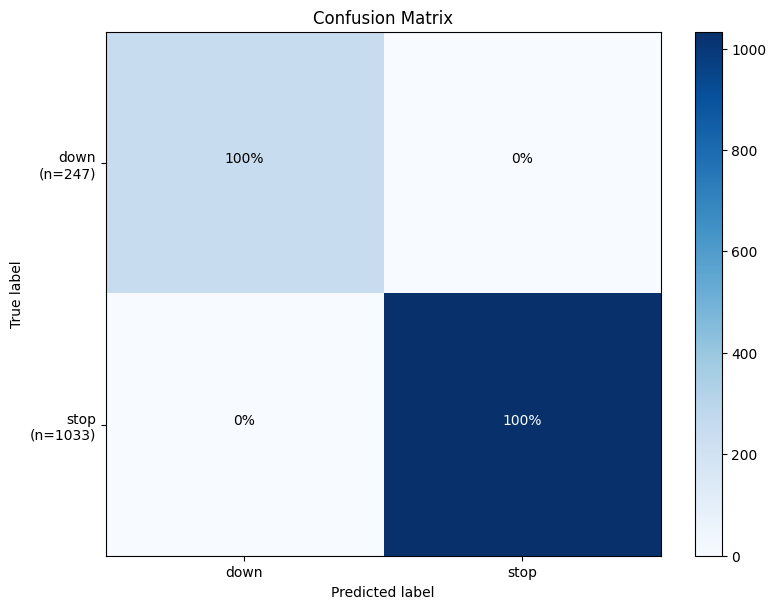

In [30]:
total_preds = []
total_labels = []
model = model_put.to(device)
model.eval()
for datas, labels in put_test_dataloader:
    if torch.cuda.is_available(): # GPU 사용 유무 확인
        datas = Variable(datas.view(-1, seq_dim, input_dim).cuda())
    else:
        datas = Variable(datas.view(-1, seq_dim, input_dim)).to(device)
    logit = model(datas).to(device)
    labels = labels.to(device).to(torch.int64).squeeze(dim=-1)
    _, preds = torch.max(logit.data, 1) # logit.data 텐서에서 최댓값의 인덱스(index)를 반환
    total_preds.extend(preds.tolist())
    total_labels.extend(labels.tolist())

print('Put 모델의 Test Precision은 {}입니다.'.format(precision_score(total_labels, total_preds)))
print('Put 모델의 Test Recall은 {}입니다.'.format(recall_score(total_labels, total_preds)))

confusion_matrix = confusion_matrix(total_labels, total_preds)
plot_confusion_matrix(confusion_matrix, labels=['down','stop'], normalize=True, title= 'Confusion Matrix')

Rotate 모델의 Test Precision은 1.0입니다.
Rotate 모델의 Test Recall은 1.0입니다.


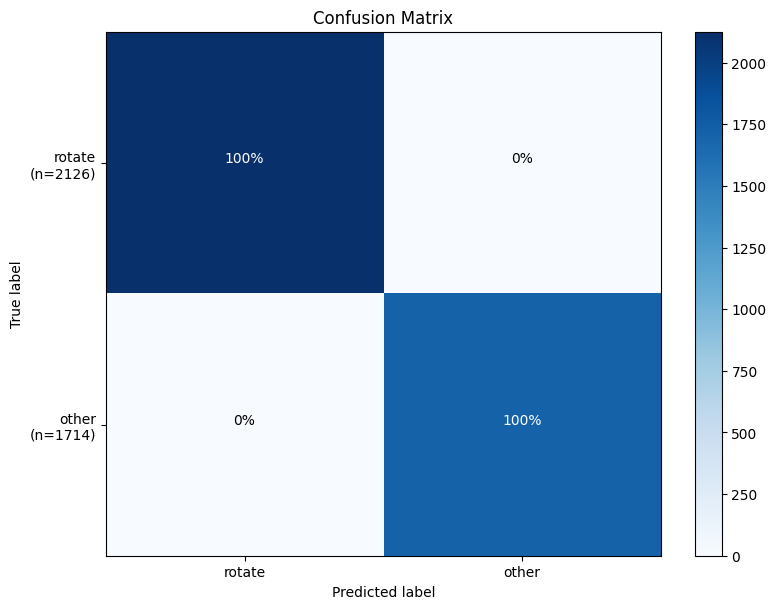

In [32]:
total_preds = []
total_labels = []
model = model_rotate.to(device)
model.eval()
for datas, labels in rotate_test_dataloader:
    if torch.cuda.is_available(): # GPU 사용 유무 확인
        datas = Variable(datas.view(-1, seq_dim, input_dim).cuda())
    else:
        datas = Variable(datas.view(-1, seq_dim, input_dim)).to(device)
    logit = model(datas).to(device)
    labels = labels.to(device).to(torch.int64).squeeze(dim=-1)
    _, preds = torch.max(logit.data, 1) # logit.data 텐서에서 최댓값의 인덱스(index)를 반환
    total_preds.extend(preds.tolist())
    total_labels.extend(labels.tolist())

print('Rotate 모델의 Test Precision은 {}입니다.'.format(precision_score(total_labels, total_preds)))
print('Rotate 모델의 Test Recall은 {}입니다.'.format(recall_score(total_labels, total_preds)))

confusion_matrix = confusion_matrix(total_labels, total_preds)
plot_confusion_matrix(confusion_matrix, labels = ['rotate','other'], normalize = True, title = 'Confusion Matrix')